# Vane Calibration
This example shows how to calibrate data that uses a vane (or a hot load) to determine the system temperature.
In the case of the GBT this applies mainly to [Argus](https://gbtdocs.readthedocs.io/en/latest/references/receivers/argus.html), although the [Q-band receiver](https://gbtdocs.readthedocs.io/en/latest/references/receivers/q-band.html) also has a vane.
For the background on the calibration please refer to [Frayer et al. 2019](https://ui.adsabs.harvard.edu/abs/2019nrao.reptE...1F/abstract).

You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/vane.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/vane.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for this example. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. 
However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. 
This is only needed if working on jupyter lab or notebook.

In [1]:
# These modules are required for the data reduction.
from dysh.fits import GBTFITSLoad

# These are only needed if working on a notebook.
#%matplotlib ipympl # Uncomment for interactive figures.
from dysh.log import init_logging

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
url = "http://www.gb.nrao.edu/dysh/example_data/fs-Argus/data/AGBT20B_295_02.raw.vegas/AGBT20B_295_02.raw.vegas.A.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

23:30:37.170 I AGBT20B_295_02.raw.vegas.A.fits already downloaded at /home/scratch/psalas/python/dysh/notebooks/examples/data


## Data Loading

Next, we use {py:class}`GBTFITSLoad <dysh.fits.GBTFITSLoad>` to load the data, and then its {py:class}`summary <dysh.fits.GBTFITSLoad.summary>` method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)

In [5]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
10,VANE,65.0,Track,1,93.173777,93.173777,1,1,25,2,166.9878,43.5400
11,SKY,65.0,Track,1,93.173777,93.173777,1,1,25,2,166.9875,43.5399
12,G24.789,65.0,Track,1,93.173777,93.173777,1,1,151,2,167.4363,43.6122


This is a frequency switched observation with Argus.
The first two scans, 10 and 11, are observations of the vane and the "cold" sky.
The next scan, 12, are the observations of the target using frequency switching.

## Data Reduction
To calibrate data using a vane we can use the same methods as with any other observations, with the difference that we must specify the ``vane`` argument.
This argument can be an integer, with the scan number of the vane observations (in this case scan 10), or it can be a {py:class}`VaneSpectrum <dysh.spectra.vane.VaneSpectrum>` object.

### Calibration with Vane
We will show how to calibrate the data providing a scan number for the ``vane`` argument.
We call {py:class}`getfs <dysh.fits.gbtfitsload.GBTFITSLoad.getfs>` with ``vane=10``.
If working from one of the GBO data reduction hosts, this will initialize a {py:class}`VaneSpectrum <dysh.spectra.vane.VaneSpectrum>` and determine the zenith opacity and atmospheric temperature from the CLEO weather forecast scripts.
If working from elsewhere, then by default these values are not known and the vane calibration will use an approximation to determine the system temperature (equation (23) in [Frayer et al. 2019](https://ui.adsabs.harvard.edu/abs/2019nrao.reptE...1F/abstract)).

For this data set we know that feeds 10 and 8 are available, we use ``fdnum=10``, and only a single spectral window and polarization are available, so we use ``ifnum=0`` and ``plnum=0``.

In [6]:
ta = sdfits.getfs(scan=12, ifnum=0, plnum=0, fdnum=10, vane=10).timeaverage()

23:30:37.439 I Vane calibrated data will be calibrated to Ta* units by default.
23:30:38.953 I Ignoring 1 blanked integration(s).
23:30:39.196 I Vane temperature (twarm): 400.15 K
23:30:39.433 I Mean zenith opacity: 0.08 nepers
23:30:39.648 I Mean atmospheric temperature: 262.66 K
23:30:39.649 I Mean calibration temperature (tcal): 413.32 K


The above messages tells us what values for the different parameters required to determine the system temperature were adopted.

Next, we plot the calibrated spectrum.

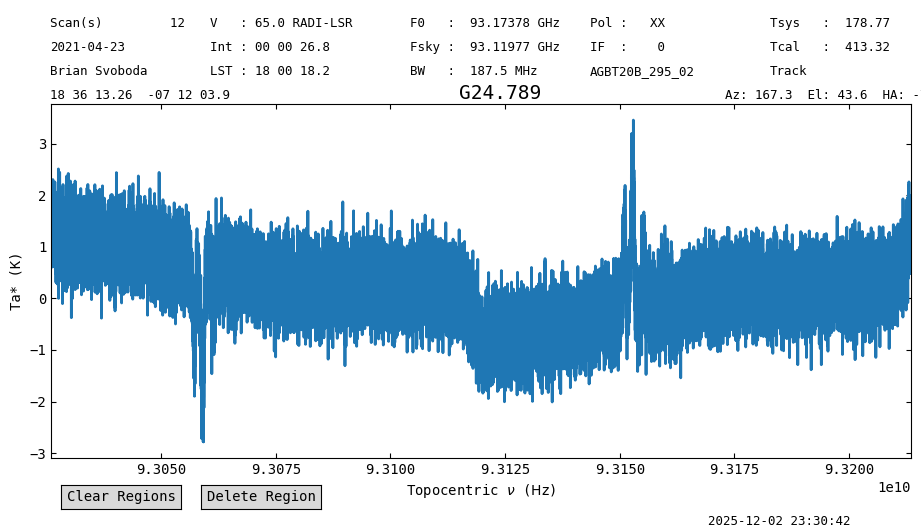

In [7]:
plot = ta.plot()

We see a clear signal at about 93.150 GHz, and it's "ghost" at 93.055 GHz.

#### Changing default values

The parameters required to determine the system temperature using a vane are: the zenith opacity (``zenith_opacity``), vane temperature (``t_warm``), atmospheric temperature (``t_atm``) and background temperature (``t_bkg``). 
From these a calibration temperature (``t_cal``) is derived. 
These can be modified by providing values for them as arguments to the calibration method.

In the following code, we modify the first four parameters used to derive the calibration temperature.
We set ``zenith_opacity=0.01`` in nepers, ``t_warm=583`` in K, ``t_atm=260`` in K and ``t_bkg=3``.
We use a higher vane temperature so we can see the difference when comparing the results.

In [8]:
ta2 = sdfits.getfs(scan=12, ifnum=0, plnum=0, fdnum=10, vane=10,
                   zenith_opacity=0.01,
                   t_warm=583,
                   t_atm=260,
                   t_bkg=3,
                  ).timeaverage()

23:30:42.818 I Vane calibrated data will be calibrated to Ta* units by default.
23:30:43.554 I Ignoring 1 blanked integration(s).
23:30:43.792 I Vane temperature (twarm): 583.00 K
23:30:43.793 I Mean calibration temperature (tcal): 584.97 K


Now we plot both results on top of each other, with the increased vane temperature spectrum in blue and the original spectrum in orange.

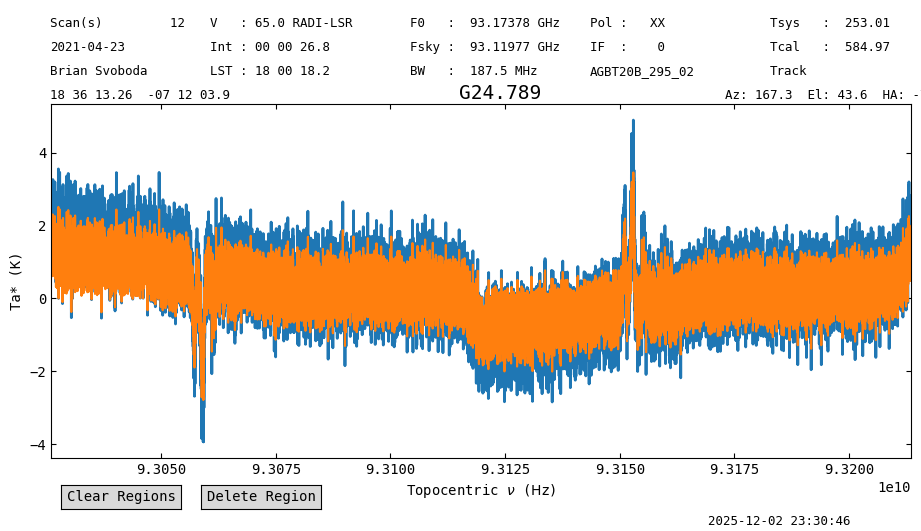

In [9]:
plot2 = ta2.plot()
plot2.oshow(ta)

The effect of having a larger vane temperature is to increase the derived system temperature, so the resulting spectrum is scaled up.

We can check the system temperature by inspecting the "TSYS" item of the ``Spectrum.meta`` dictionary.

In [10]:
print(ta.meta["TSYS"], ta2.meta["TSYS"])

178.76694728214542 253.01146158520933


Alternatively, we can directly provide a value for the calibration temperature, and get the same result.
From the output of the previous example, we had a calibration temperature of 584.97 K.

In [11]:
ta3 = sdfits.getfs(scan=12, ifnum=0, plnum=0, fdnum=10, vane=10,
                   t_cal=584.97
                  ).timeaverage()

23:30:47.166 I Vane calibrated data will be calibrated to Ta* units by default.
23:30:47.888 I Ignoring 1 blanked integration(s).


We plot this and the previous result on top of each other to confirm that they are the same.

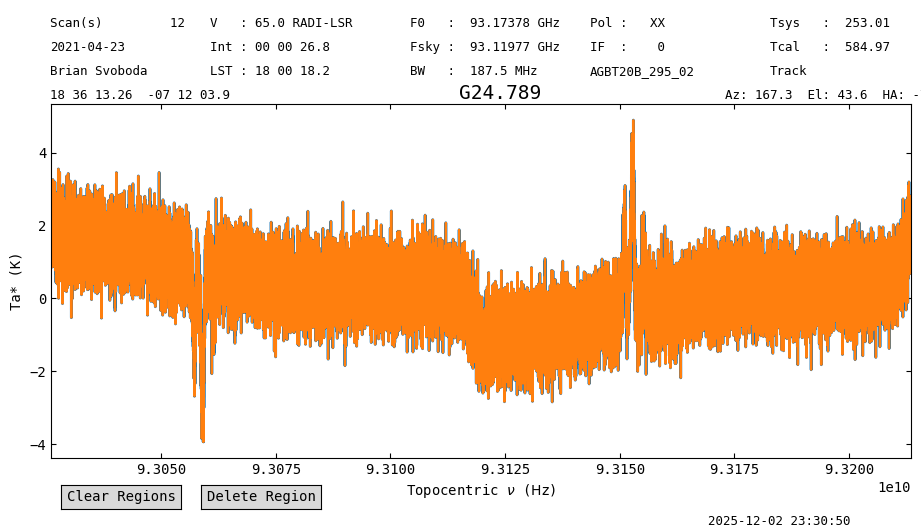

In [12]:
plot3 = ta3.plot()
plot3.oshow(ta2)

## Creating a VaneSpectrum Object

For more control, or developing alternative data reduction approaches, one could create a {py:class}`VaneSpectrum <dysh.spectra.vane.VaneSpectrum>` object directly.
There are two ways of doing so, using {py:class}`getvane <dysh.fits.gbtfitsload.GBTFITSLoad.getvane>`, or directly instanciating a {py:class}`VaneSpectrum <dysh.spectra.vane.VaneSpectrum>` object by directly providing the input values, or from a {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>` object using {py:class}`VaneSpectrum.from_spectrum <dysh.spectra.vane.VaneSpectrum.from_spectrum>`. 
Here we will show how to use {py:class}`getvane <dysh.fits.gbtfitsload.GBTFITSLoad.getvane>`.

The arguments are the same as those provided for the calibration.

In [13]:
vane = sdfits.getvane(scan=10, ifnum=0, plnum=0, fdnum=10, 
                      zenith_opacity=0.01,
                      t_warm=583,
                      t_atm=260,
                      t_bkg=3)

The calibration temperature can be obtained using the {py:class}`VaneSpectrum.get_tcal <dysh.spectra.vane.VaneSpectrum.get_tcal>` method.
This takes as input a reference {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>`.
For example:

In [14]:
ref = sdfits.gettp(scan=11, ifnum=0, plnum=0, fdnum=10).timeaverage()

23:30:52.037 I Using TSYS column


In [15]:
vane.get_tcal(ref)

23:30:52.376 I Vane temperature (twarm): 583.00 K
23:30:52.378 I Mean calibration temperature (tcal): 584.98 K


np.float64(584.9782633701202)

And the system temperature using the {py:class}`VaneSpectrum.get_tsys <dysh.spectra.vane.VaneSpectrum.get_tsys>` method, which also takes as input a reference {py:class}`Spectrum <dysh.spectra.spectrum.Spectrum>`.

In [16]:
vane.get_tsys(ref)

23:30:52.387 I Vane temperature (twarm): 583.00 K
23:30:52.388 I Mean calibration temperature (tcal): 584.98 K


np.float64(250.1676896502541)

As mentioned earlier, it is also possible to directly provide a {py:class}`VaneSpectrum <dysh.spectra.vane.VaneSpectrum>` to the calibration methods. In this case, the additional parameters (``t_warm``, ``t_atm``, ``t_bkg`` and ``t_cal`` are ignored).
For example:

23:30:52.395 I Vane calibrated data will be calibrated to Ta* units by default.
23:30:52.396 I Will use a zenith opacity of 0.01 nepers. Taken from vane.
23:30:52.540 I Ignoring 1 blanked integration(s).
23:30:52.781 I Vane temperature (twarm): 583.00 K
23:30:52.782 I Mean calibration temperature (tcal): 584.97 K


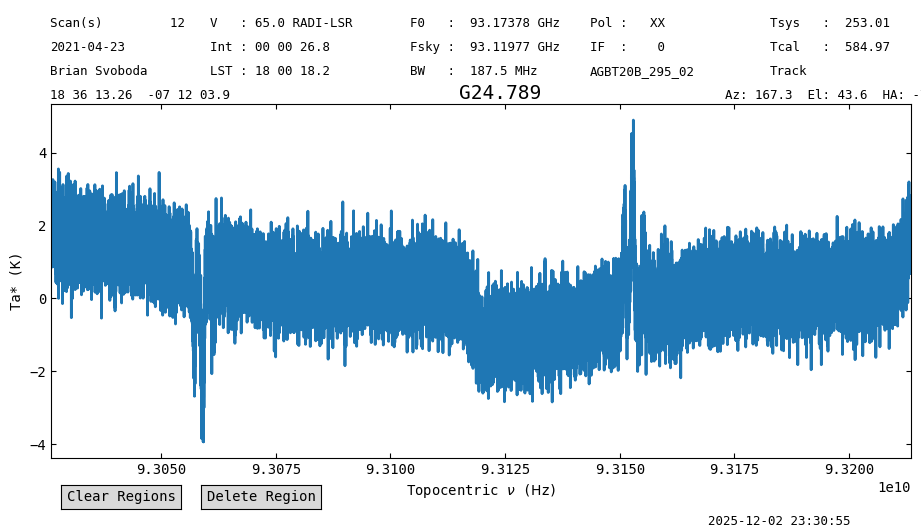

In [17]:
ta4 = sdfits.getfs(scan=12, ifnum=0, plnum=0, fdnum=10, vane=vane).timeaverage()
plot4 = ta4.plot()

We also note that when providing the ``vane`` argument during calibration, the system temperature argument ``t_sys`` is ignored.